This python notebook is the implementation of the "Getting Started" tutorial of Tensorflow given in the following page.

URL - https://www.tensorflow.org/get_started/eager

Each step in the tutorial will be a cell

In [1]:
# Step 1 - Install the latest version of Tensorflow - Done that

In [2]:
# Step 2 - Configure imports and eager execution
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("Tensorflow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Tensorflow version: 1.8.0
Eager execution: True


In [5]:
# Iris Classification Problem
# Step 3 - Import and parse the training dataset

# Note - This code did not work for me, as I kept getting
#  a certificate error, indicating an issue with SSL
# I just downloaded the dataset manually, and put it into 
# ~/.keras/datasets/

train_dataset_url = "https://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/gautam/.keras/datasets/iris_training.csv


In [6]:
# Iris Classification Problem
# Step 4 - Inpect the data

!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [7]:
# Iris Classification Problem
# Step 5 - Parse the dataset

def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0]] # sets field types
    parsed_line = tf.decode_csv(line, example_defaults)
    # First 4 fields are features, combine into single tensor
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In [8]:
# Iris Classification Problem
# Step 6 - Create the training tf.data.Dataset

train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1) # skip the first header row
train_dataset = train_dataset.map(parse_csv) # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000) # randomize
train_dataset = train_dataset.batch(32) # set batch size to 32

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features: ", features[0])
print("example label: ", label[0])

example features:  tf.Tensor([7.7 2.8 6.7 2. ], shape=(4,), dtype=float32)
example label:  tf.Tensor(2, shape=(), dtype=int32)


In [11]:
# Iris Classification Problem
# Step 7 - Create a model using Keras

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

In [12]:
# Iris Classification Problem
# Step 8 - Define Loss and Gradient Functions

def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [13]:
# Iris Classification Problem
# Step 9 - Create an optimizer

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [16]:
# Iris Classification Problem
# Step 10 - Training Loop

train_loss_results = []
train_accuracy_results = []

num_epochs = 501

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x,y in train_dataset:
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                 global_step=tf.train.get_or_create_global_step())
        
        
        epoch_loss_avg(loss(model, x, y))
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

        

Epoch 000: Loss: 0.087, Accuracy: 97.500%
Epoch 050: Loss: 0.067, Accuracy: 97.500%
Epoch 100: Loss: 0.076, Accuracy: 96.667%
Epoch 150: Loss: 0.077, Accuracy: 98.333%
Epoch 200: Loss: 0.066, Accuracy: 97.500%
Epoch 250: Loss: 0.067, Accuracy: 99.167%
Epoch 300: Loss: 0.056, Accuracy: 99.167%
Epoch 350: Loss: 0.067, Accuracy: 97.500%
Epoch 400: Loss: 0.059, Accuracy: 98.333%
Epoch 450: Loss: 0.064, Accuracy: 98.333%
Epoch 500: Loss: 0.060, Accuracy: 97.500%


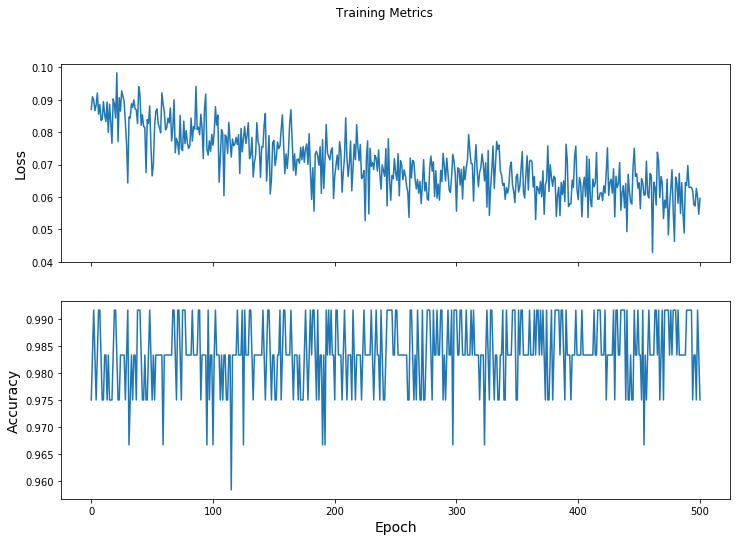

In [19]:
# Iris Classification Problem
# Step 11 - Visualize the loss function over time

fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [36]:
# Iris Classification Problem
# Step 12 - Setup the test dataset

test_url = "https://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                 origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

In [37]:
# Iris Classification Problem
# Step 13 - Evaluate the model on the test dataset

test_accuracy = tfe.metrics.Accuracy()
for (x,y) in test_dataset:
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [38]:
# Iris Classification Problem
# Step 14 - Use the trained model to make predictions

class_ids = ['Iris sentosa', 'Iris versicolor', 'Iris virginica']

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5, ],
    [5.9, 3.0, 4.2, 1.5, ],
    [6.9, 3.1, 5.4, 2.1, ]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = class_ids[class_idx]
    print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris sentosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
